In [42]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [43]:
import numpy as np
import pandas as pd

In [44]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [45]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [46]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [47]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [48]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [49]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [50]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [51]:
engine.execute('SELECT * FROM measurement').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0),
 (11, 'USC00519397', '2010-01-12', 0.0, 61.0),
 (12, 'USC00519397', '2010-01-14', 0.0, 66.0),
 (13, 'USC00519397', '2010-01-15', 0.0, 65.0),
 (14, 'USC00519397', '2010-01-16', 0.0, 68.0),
 (15, 'USC00519397', '2010-01-17', 0.0, 64.0),
 (16, 'USC00519397', '2010-01-18', 0.0, 72.0),
 (17, 'USC00519397', '2010-01-19', 0.0, 66.0),
 (18, 'USC00519397', '2010-01-20', 0.0, 66.0),
 (19, 'USC00519397', '2010-01-21', 0.0, 69.0),
 (20, 'USC00519397', '2010-01-22', 0.0, 67.0),
 (21, 'USC00519397', '2010-01-23', 0.0, 67.0),
 (22, 'USC00519397

# Exploratory Climate Analysis

The last date of record is 2017-08-23.
Therefore,Last 12 months date is 2016-08-23


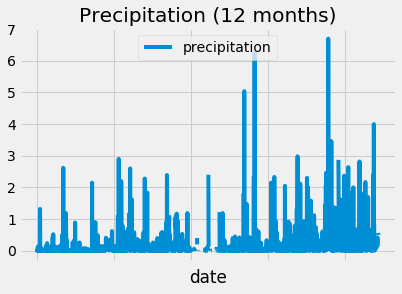

In [52]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(f"The last date of record is {latest_date}.")


# Calculate the date 1 year ago from the last data point in the database
latest_date_1 = dt.datetime.strptime(latest_date,'%Y-%m-%d')

past_twelve_months_date = (latest_date_1 - dt.timedelta(days=365))
ptmd=past_twelve_months_date.strftime('%Y-%m-%d')
print(f"Therefore,Last 12 months date is {ptmd}")

# Perform a query to retrieve the data and precipitation scores
last_twelve_months_data = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date<latest_date).\
filter(Measurement.date>past_twelve_months_date).all()
#print(last_twelve_months_data)

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(last_twelve_months_data,columns=['date', 'precipitation'])
prcp_df.set_index('date',inplace=True)
# Sort the dataframe by date
sorted_df = prcp_df.sort_values('date')
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(title="Precipitation (12 months)")
plt.legend(loc='upper center')

plt.rcParams["figure.figsize"]=(25,10)
plt.savefig("Images/Precipitation_by_date.png")
plt.show()

![precipitation](Images/precipitation.png)

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2011.000000
mean,0.176549
std,0.460667
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [13]:
# Design a query to show how many stations are available in this dataset?
query = session.query(Measurement.station).distinct().count()
print("{} Stations are available in dataset".format(query))

9 Stations are available in dataset


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_order= session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()
station_order

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
#Most active staions
most_active_station = station_order[0][0]
print(f"Most Active staion :{most_active_station}")

Most Active staion :USC00519281


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
filter(Measurement.station == most_active_station).all()
temp

[(54.0, 85.0, 71.66378066378067)]

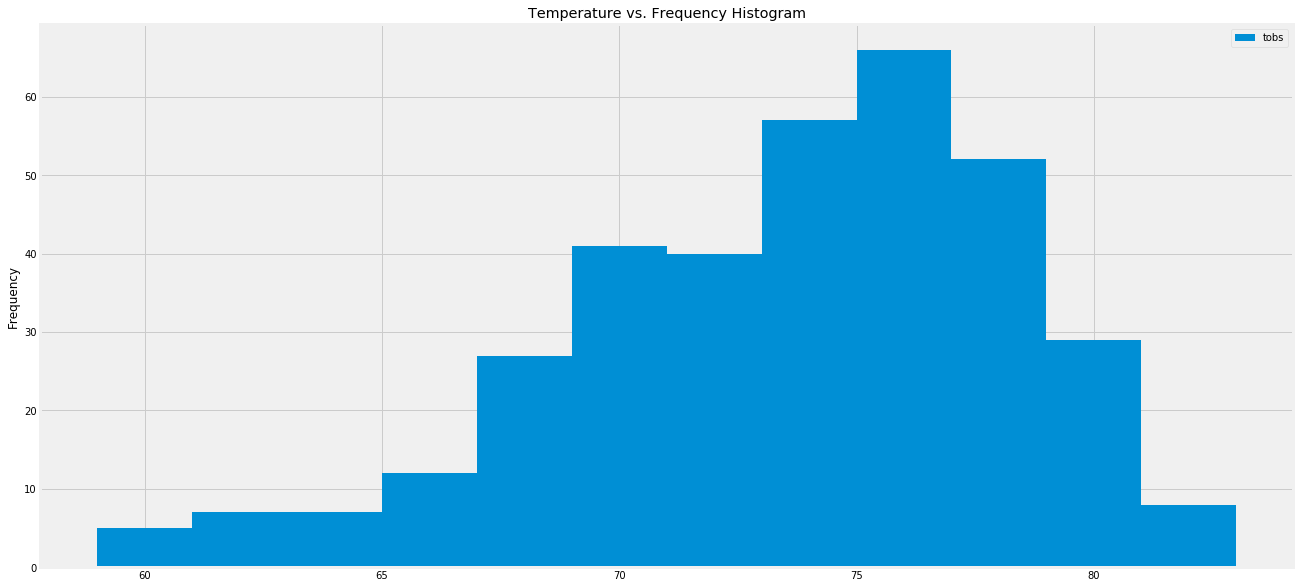

In [17]:
# Choose the station with the highest number of temperature observations.
max_temp_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).first()
max_temp_station= max_temp_station[0]

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_observations = session.query( Measurement.tobs).filter(Measurement.date >= past_twelve_months_date).\
filter(Measurement.station == max_temp_station).all()
last_observations = pd.DataFrame(last_observations, columns=['tobs'])
last_observations

last_observations.plot.hist(bins=12, title="Temperature vs. Frequency Histogram")
plt.savefig("Images/Frequency.png")
plt.show()

![precipitation](Images/station-histogram.png)

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = calc_temps('2017-07-03','2017-07-17')
trip

[(69.0, 78.22105263157894, 87.0)]

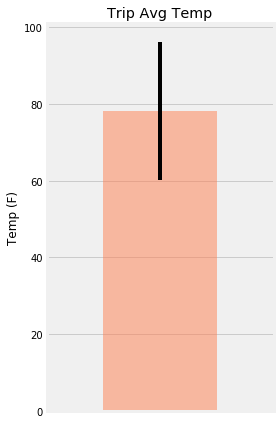

In [20]:
# Plot the results from your previous query as a bar chart. 
trip_df = pd.DataFrame(trip, columns=['tmin', 'tavg', 'tmax'])

trip_df.plot.bar(y='tavg', yerr=(trip_df['tmax'] - trip_df['tmin']), color='coral', alpha=0.5, figsize=(4,6))
# Use "Trip Avg Temp" as your Title
plt.title("Trip Avg Temp")
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()
plt.savefig("Images/Trip_Avg_Temp.png")
plt.show()

In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def precipitation(start_date, end_date):
    
    sel = [Measurement.station, 
           Station.name, 
           Station.latitude, 
           Station.longitude, 
           Station.elevation,  
           Measurement.prcp]
    
    return session.query(*sel).filter(Measurement.station == Station.station).\
filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

print(precipitation('2017-07-03','2017-07-17'))


[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.4), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.15), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.13), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.04), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.02), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, None), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]


## Optional Challenge Assignment

In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [23]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-07-03'
end_date ='2017-07-17'
# Use the start and end date to create a range of dates
dates = session.query(Measurement.date).filter(Measurement.date >= start_date).\
filter(Measurement.date <= end_date).group_by(Measurement.date).all()
# Stip off the year and save a list of %m-%d strings
trip_dates = [x[0] for x in dates]
trip_dates_stripped= [x[5:] for x in trip_dates]

start_month_day = trip_dates_stripped[0]
end_month_day = trip_dates_stripped[-1]


# Loop through the list of %m-%d strings and calculate the normals for each date
daily_normals = [session.query(func.min(Measurement.tobs),func.avg(Measurement.tobs),func.max(Measurement.tobs)).\
                 filter(func.strftime("%m-%d", Measurement.date) >= start_month_day).\
                 filter(func.strftime("%m-%d", Measurement.date) <= end_month_day).\
                 group_by(func.strftime("%m-%d", Measurement.date)).all()]

daily_normals = daily_normals[0]

daily_normals

[(68.0, 75.32075471698113, 87.0),
 (70.0, 76.57142857142857, 81.0),
 (66.0, 75.0, 81.0),
 (69.0, 75.0, 81.0),
 (69.0, 74.91071428571429, 82.0),
 (69.0, 76.08333333333333, 83.0),
 (68.0, 76.19298245614036, 83.0),
 (68.0, 75.62068965517241, 82.0),
 (70.0, 75.78947368421052, 81.0),
 (67.0, 75.96491228070175, 82.0),
 (69.0, 76.1896551724138, 81.0),
 (61.0, 76.2280701754386, 82.0),
 (68.0, 76.2542372881356, 82.0),
 (70.0, 76.34482758620689, 83.0),
 (70.0, 76.30188679245283, 83.0)]

In [24]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normals_df= pd.DataFrame(daily_normals,columns=['tmin', 'tavg', 'tmax'])

daily_normals_df['date']=pd.to_datetime(daily_normals_df['date'])
#daily_normals['date'] = pd.to_datetime(daily_normals['date'])
daily_normals_df.set_index('date',inplace=True)

daily_normals_df['date']

KeyError: 'date'

<IPython.core.display.Javascript object>


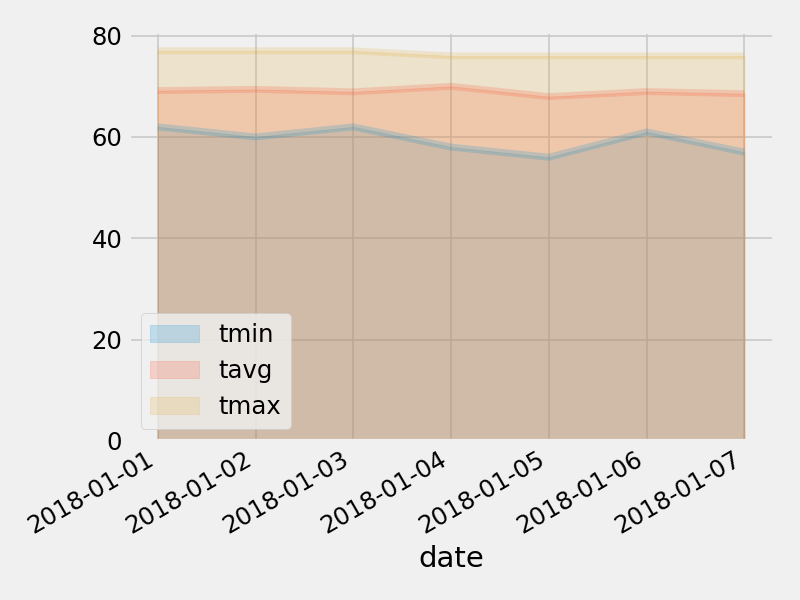

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
